## South African Heart Disease Classifier with Model Tuning

Context:
A retrospective sample of males in a heart-disease high-risk region of the Western Cape, South Africa. There are roughly two controls per case of CHD. Many of the CHD positive men have undergone blood pressure reduction treatment and other programs to reduce their risk factors after their CHD event. In some cases the measurements were made after these treatments. These data are taken from a larger dataset, described in Rousseauw et al, 1983, South African Medical Journal.

The class label indicates if the person has a coronary heart disease (CHD): negative (0) or positive (1).

Attributes description:

sbp: systolic blood pressure [101, 218]
tobacco: cumulative tobacco (kg) [0.0, 31.2]
ldl: low densiity lipoprotein cholesterol [0.98, 15.33]
adiposity [6.74, 42.49]
famhist: family history of heart disease (Present, Absent)
typea: type-A behavior (Aggressive ,combative, impulsive, urgency and very tense type behavior in person) [13, 78]
obesity [14.7, 46.58]
alcohol: current alcohol consumption [0.0, 147.19]
age: age at onset [15, 64]

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#
import warnings
warnings.filterwarnings("ignore")
#

In [3]:
df = pd.read_csv('saheart.dat',sep = ',', header = 13, names = ['Sbp', 'Tobacco', 'Ldl', 'Adiposity',
                                                                'Famhist', 'Typea', 'Obesity', 'Alcohol', 'Age', 'Chd'])
df.head()

,Sbp,Tobacco,Ldl,Adiposity,Famhist,Typea,Obesity,Alcohol,Age,Chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


# Brief Exploration of the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sbp        462 non-null    int64  
 1   Tobacco    462 non-null    float64
 2   Ldl        462 non-null    float64
 3   Adiposity  462 non-null    float64
 4   Famhist    462 non-null    object 
 5   Typea      462 non-null    int64  
 6   Obesity    462 non-null    float64
 7   Alcohol    462 non-null    float64
 8   Age        462 non-null    int64  
 9   Chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 36.2+ KB


In [5]:
df.Famhist.replace(['Absent', 'Present'], [0,1], inplace = True)

In [6]:
df.describe()

,Sbp,Tobacco,Ldl,Adiposity,Famhist,Typea,Obesity,Alcohol,Age,Chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,0.415584,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,0.493357,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,0.000000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,0.000000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,0.000000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,1.000000,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,1.000000,78.000000,46.580000,147.190000,64.000000,1.000000


- Alcohol has a steep steps indicating a heavily skewed distribution
- Tobacco and Ldl also has a steep increase from the 75% to the max 

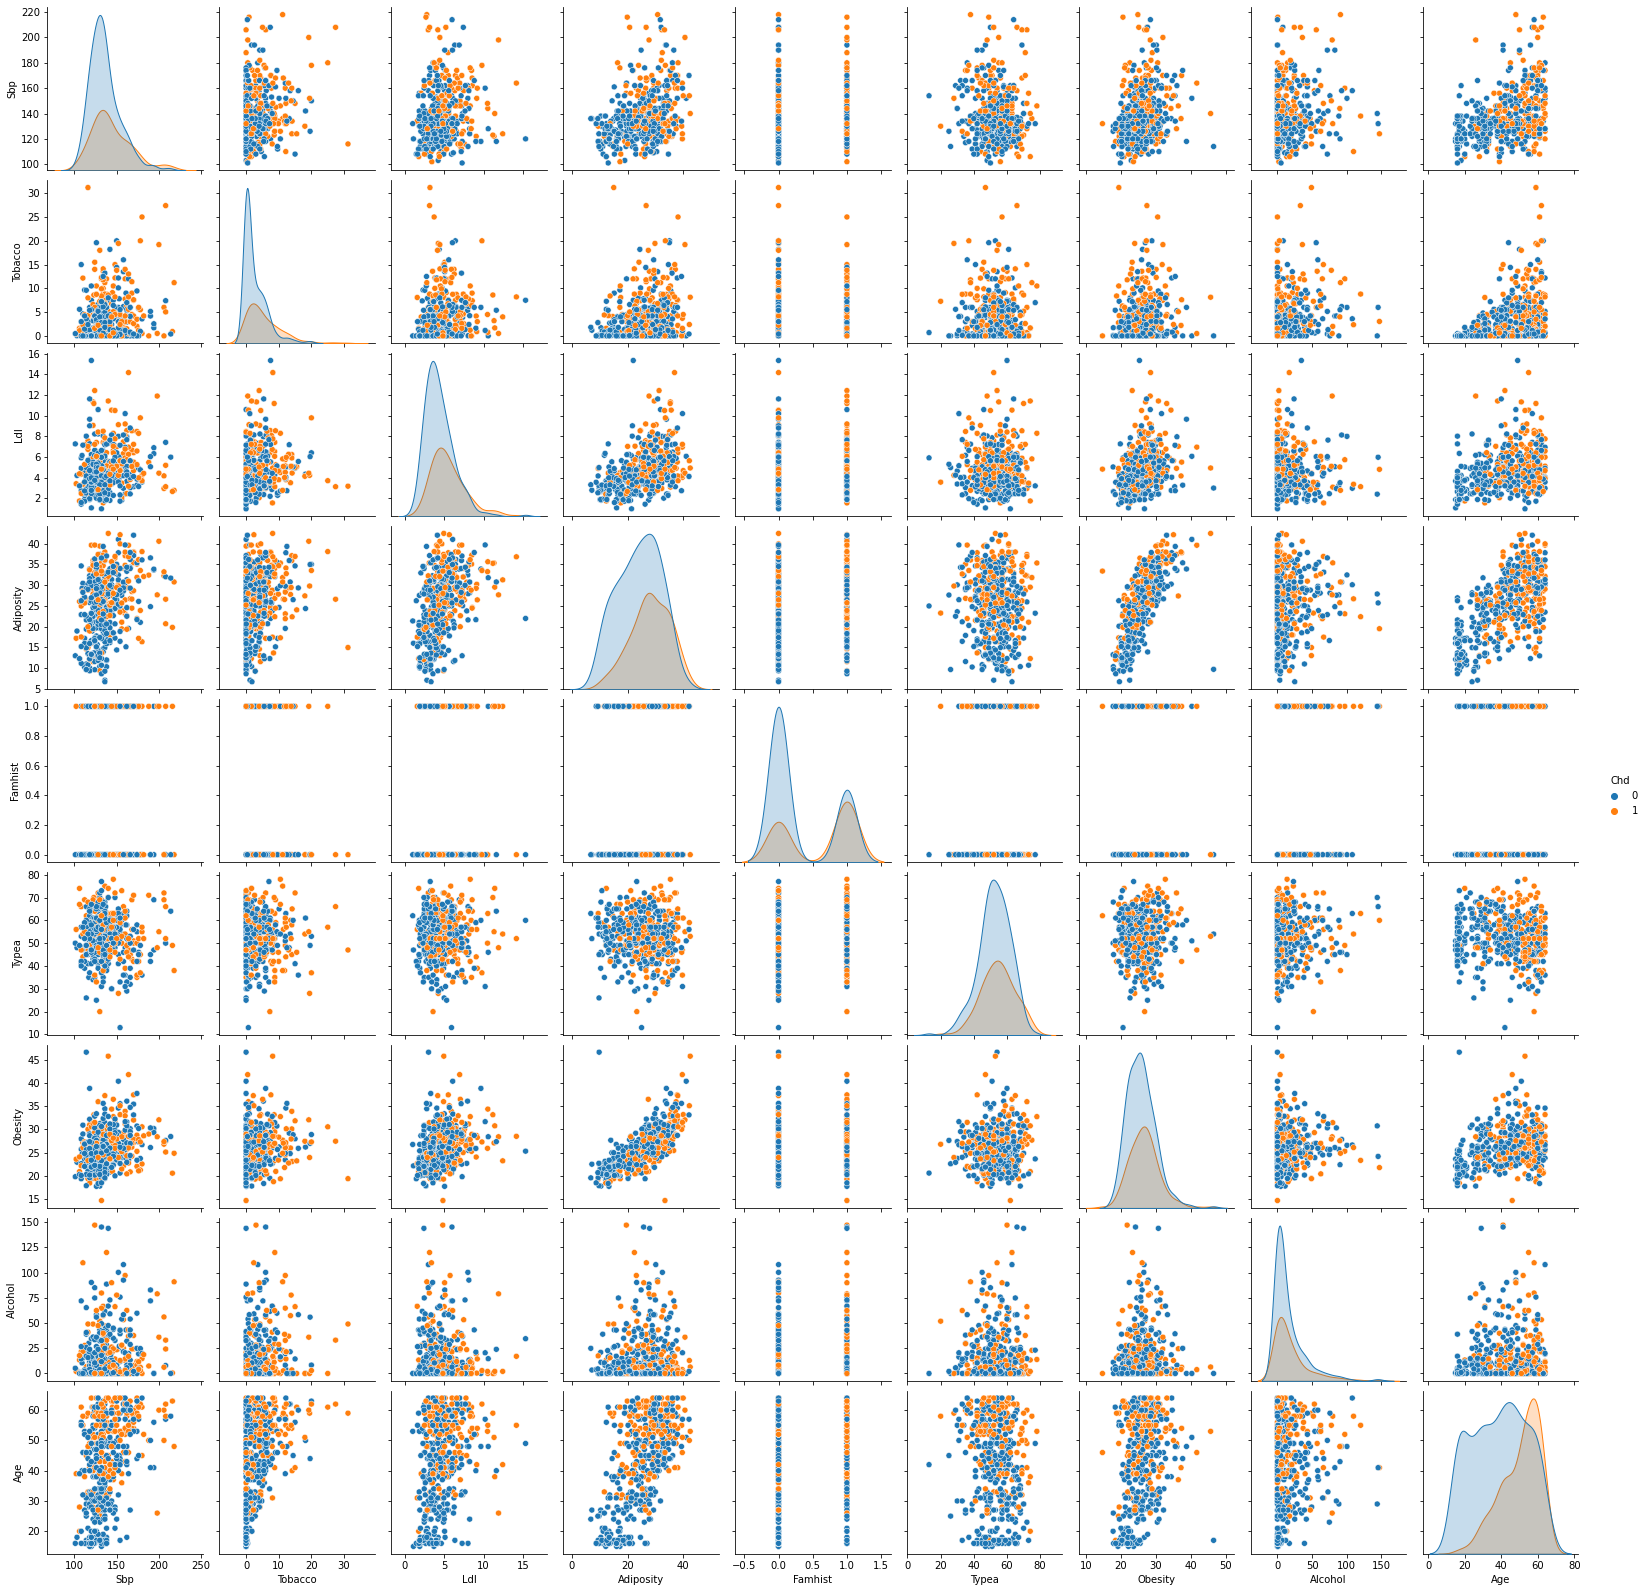

In [8]:
import seaborn as sns
sns.pairplot(df, diag_kind= 'kde', hue = 'Chd')
plt.show()

- None of the predictors by themselves seem to have a strong relation with the target
- There is some linear relationship between Adiposity and Obesity

#### Outlier check

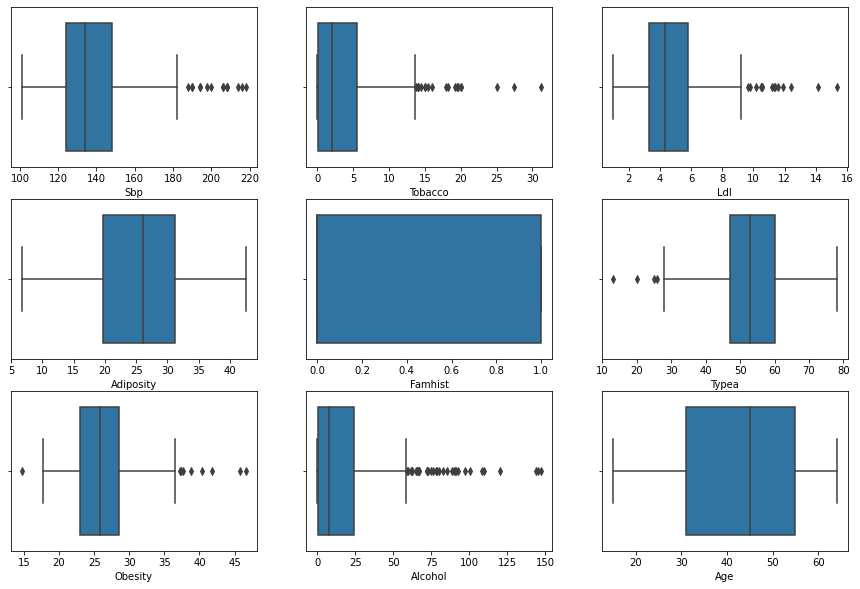

In [9]:
plt.figure(figsize=(15,10))
pos = 1
for i in df.drop(columns = 'Chd').columns:
    plt.subplot(3, 3, pos)
    sns.boxplot(df[i])
    pos += 1 

- There are quiet a lot of outliers
- Lets treat them. But before that, we shall divide the entire data into train and test and treat only the train data, to maintain the sanctity of the test set

( try to use the dataset as it is, without treating the outliers and compare the performances of a given model, with and without outlier treatment)

#### Train test split

In [10]:
X = df.drop(columns= 'Chd')
y = df.Chd

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((369, 9), (93, 9), (369,), (93,))

In [12]:
for i in X_train.columns:
    q1, q2, q3 = X_train[i].quantile([0.25,0.5,0.75])
    IQR = q3 - q1
    a = X_train[i] > q3 + 1.5*IQR
    b = X_train[i] < q1 - 1.5*IQR
    X_train[i] = np.where(a | b, q2, X_train[i])  # Median imputation for outliers
    # X_train[i] = np.where(a, q3, X_train[i]) # Capping to address outliers
    # X_train[i] = np.where(b, q1, X_train[i]) # Capping

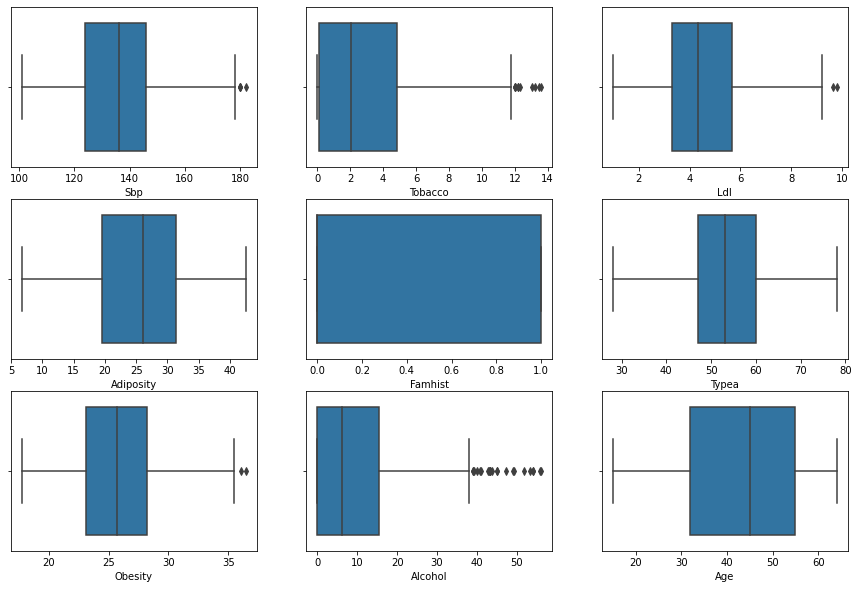

In [13]:
plt.figure(figsize=(15,10))
pos = 1
for i in X_train.columns:
    plt.subplot(3, 3, pos)
    sns.boxplot(X_train[i])
    pos += 1 

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [15]:
from sklearn.metrics import confusion_matrix

pred = logreg.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

lr_score = logreg.score(X_test, y_test)
lr_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
lr_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
lr_specificity =round(tn/(tn+fp),3)    # Of all the people without Chds, how many were recognised to not have Chd

result = pd.DataFrame({'Model' : ['Logistic Regression'], 'Accuracy' : [lr_score], 'Precision' : [lr_precision],
                      'True positive rate' : [lr_recall], 'True negative rate' : [lr_specificity],
                       'False positive rate' :  [1-lr_specificity]})
result

,Model,Accuracy,Precision,True positive rate,True negative rate,False positive rate
0,Logistic Regression,0.752688,0.68,0.531,0.869,0.131


Meh...

**What can we do to make it better????**

In [16]:
y_train.value_counts()

0    241
1    128
Name: Chd, dtype: int64

Smells like class imbalance, lets UP Sample!!! 

In [17]:
train = pd.concat([X_train, y_train], axis = 1)

extra_samples = train[train['Chd'] == 1].sample(n = 100, random_state = 1)

train_upsampled = pd.concat([train, extra_samples], axis = 0)

In [18]:
#Importing SMOTE
from imblearn.over_sampling import SMOTE
#
#upsamp=SMOTE(sampling_strategy='auto',k_neighbors=7, random_state=10)
upsamp=SMOTE(sampling_strategy=0.85)
#upsamp=SMOTE(sampling_strategy='auto',k_neighbors=7, random_state=10)
#upsamp=SMOTE(sampling_strategy='auto',k_neighbors=7, random_state=10)
X_train_sm, y_train_sm=upsamp.fit_resample(X_train,y_train)

In [19]:
X_train = train_upsampled.drop(columns = 'Chd')
y_train = train_upsampled.Chd

X_train.shape

y_train.value_counts()

0    241
1    228
Name: Chd, dtype: int64

In [20]:

X_train_sm.shape

y_train_sm.value_counts()

0    241
1    204
Name: Chd, dtype: int64

In [21]:
logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train, y_train)

pred = logreg.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

lr_score = logreg.score(X_test, y_test)
lr_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
lr_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
lr_specificity =round(tn/(tn+fp),3)    # Of all the people without Chds, how many were recognised to not have Chd

result = pd.DataFrame({'Model' : ['Logistic Regression'], 'Accuracy' : [lr_score], 'Precision' : [lr_precision],
                      'True positive rate' : [lr_recall], 'True negative rate' : [lr_specificity],
                       'False positive rate' :  [1-lr_specificity]})
result

,Model,Accuracy,Precision,True positive rate,True negative rate,False positive rate
0,Logistic Regression,0.752688,0.615,0.75,0.754,0.246


In [22]:
logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train_sm, y_train_sm)

pred = logreg.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

lr_score = logreg.score(X_test, y_test)
lr_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
lr_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
lr_specificity =round(tn/(tn+fp),3)    # Of all the people without Chds, how many were recognised to not have Chd

result = pd.DataFrame({'Model' : ['Logistic Regression'], 'Accuracy' : [lr_score], 'Precision' : [lr_precision],
                      'True positive rate' : [lr_recall], 'True negative rate' : [lr_specificity],
                       'False positive rate' :  [1-lr_specificity]})
result

,Model,Accuracy,Precision,True positive rate,True negative rate,False positive rate
0,Logistic Regression,0.72043,0.579,0.688,0.738,0.262


- Accuracy remained the same but there is some good increase in the True positive rate 😃
- And some good decrease in the True negative rate 😐

What can we do? 
Lets see if we can improve the predicitons with a different threshold value

In [23]:
from sklearn.preprocessing import binarize
from sklearn.metrics import accuracy_score, roc_auc_score
 
t = 0.4   #threshold
proba = logreg.predict_proba(X_test)
pred_at_t = binarize(proba, t)[:,1]

tn, fp, fn, tp = confusion_matrix(y_test, pred_at_t).ravel()

lr_score = accuracy_score(y_test, pred_at_t)
lr_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
lr_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
lr_specificity =round(tn/(tn+fp),3)    # Of all the people without Chds, how many were recognised to not have Chd

result.loc[1] = [f'Logistic Regression(t={t})', lr_score, lr_precision, lr_recall, lr_specificity, 1-lr_specificity]
result

,Model,Accuracy,Precision,True positive rate,True negative rate,False positive rate
0,Logistic Regression,0.720430,0.579,0.688,0.738,0.262
1,Logistic Regression(t=0.4),0.688172,0.529,0.844,0.607,0.393


- One could call that an improvement 🤐

#### If you can't change the model, CHANGE the model

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=1)

dt.fit(X_train, y_train)

pred = dt.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

dt_score = dt.score(X_test, y_test)
dt_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
dt_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
dt_specificity =round(tn/(tn+fp),3)    # Of all the people without Chds, how many were recognised to not have Chd

result.loc[2] = ['Decision Tree', dt_score, dt_precision, dt_recall, dt_specificity, 1-dt_specificity]
result

,Model,Accuracy,Precision,True positive rate,True negative rate,False positive rate
0,Logistic Regression,0.720430,0.579,0.688,0.738,0.262
1,Logistic Regression(t=0.4),0.688172,0.529,0.844,0.607,0.393
2,Decision Tree,0.612903,0.417,0.312,0.770,0.230


In [20]:
# Lets change the max depth

dt = DecisionTreeClassifier(max_depth= 4, random_state=1)

dt.fit(X_train, y_train)

pred = dt.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

dt_score = dt.score(X_test, y_test)
dt_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
dt_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
dt_specificity =round(tn/(tn+fp),3)    # Of all the people without Chds, how many were recognised to not have Chd

result.loc[2] = ['Decision Tree', dt_score, dt_precision, dt_recall, dt_specificity, 1-dt_specificity]
result

,Model,Accuracy,Precision,True positive rate,True negative rate,False positive rate
0,Logistic Regression,0.752688,0.615,0.750,0.754,0.246
1,Logistic Regression(t=0.4),0.698925,0.538,0.875,0.607,0.393
2,Decision Tree,0.741935,0.618,0.656,0.787,0.213


In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)

rf.fit(X_train, y_train)

pred = rf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

rf_score = rf.score(X_test, y_test)
rf_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
rf_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
rf_specificity =round(tn/(tn+fp),3) 

result.loc[3] = ['Random Forest', rf_score, rf_precision, rf_recall, rf_specificity, 1 - rf_specificity]
result

,Model,Accuracy,Precision,True positive rate,True negative rate,False positive rate
0,Logistic Regression,0.720430,0.579,0.688,0.738,0.262
1,Logistic Regression(t=0.4),0.688172,0.529,0.844,0.607,0.393
2,Decision Tree,0.612903,0.417,0.312,0.770,0.230
3,Random Forest,0.666667,0.522,0.375,0.820,0.180


In [26]:
# Takes very long. The cell below has the best params that was obtained when this cell was executed

from sklearn.model_selection import GridSearchCV

grid = {'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600]}

gs = GridSearchCV(estimator = RandomForestClassifier(random_state=1), param_grid = grid, cv = 10, n_jobs = -1, verbose = 2 )

gs.fit(X_train, y_train)
#gs.predict(X_test)

gs.best_params_


Fitting 10 folds for each of 1188 candidates, totalling 11880 fits


{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

In [23]:
forest = RandomForestClassifier( bootstrap = False,
  max_depth = 10,
  max_features =  'auto' ,
  min_samples_leaf = 1,
  min_samples_split = 2,
  n_estimators = 600, random_state= 1)

forest.fit(X_train, y_train)

pred = forest.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

forest_score = forest.score(X_test, y_test)
forest_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
forest_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
forest_specificity =round(tn/(tn+fp),3) 

result.loc[4] = ['Random forest(tuned)', forest_score, forest_precision, forest_recall, forest_specificity, 1 - forest_specificity]
result

,Model,Accuracy,Precision,True positive rate,True negative rate,False positive rate
0,Logistic Regression,0.752688,0.615,0.750,0.754,0.246
1,Logistic Regression(t=0.4),0.698925,0.538,0.875,0.607,0.393
2,Decision Tree,0.741935,0.618,0.656,0.787,0.213
3,Random Forest,0.666667,0.522,0.375,0.820,0.180
4,Random forest(tuned),0.677419,0.556,0.312,0.869,0.131


- Random forest does not seem like a good option for this data

In [ ]:
# Example of Randomforest classifier tuning using RandomSearchCV
rf = RandomForestClassifier(n_jobs=8)

    param_dist = {
        "n_estimators":sp_randint(100,300),
        "criterion": ["gini"],
        #"max_depth": sp_randint(3, 10000),
        #"min_samples_split": sp_randint(1, 300),
        #"min_samples_leaf": sp_randint(1, 300),
        "max_features": sp_randint(10, 26),
        "bootstrap": [True, False],
        'random_state':sp_randint(1, 1000000),
        }

    clf = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=50,cv=10,scoring='roc_auc')

    clf.fit(train_x, train_y)
    valid_predictions = clf.predict_proba(valid_x)[:, 1]
    test_predictions= clf.predict_proba(test_x)[:, 1]

    loss = roc_auc_score(valid_y,valid_predictions)
    print('loss:')
    print(loss)
    print(clf.best_estimator_)

In [24]:
from sklearn.svm import SVC

svm = SVC(C=1, gamma=1, kernel='rbf')


svm.fit(X_train, y_train)

pred = svm.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

svm_score = svm.score(X_test, y_test)
svm_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
svm_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
svm_specificity =round(tn/(tn+fp),3) 

result.loc[5] = ['SVM', svm_score, svm_precision, svm_recall, svm_specificity, 1 - svm_specificity]
result

,Model,Accuracy,Precision,True positive rate,True negative rate,False positive rate
0,Logistic Regression,0.752688,0.615,0.750,0.754,0.246
1,Logistic Regression(t=0.4),0.698925,0.538,0.875,0.607,0.393
2,Decision Tree,0.741935,0.618,0.656,0.787,0.213
3,Random Forest,0.666667,0.522,0.375,0.820,0.180
4,Random forest(tuned),0.677419,0.556,0.312,0.869,0.131
5,SVM,0.655914,NaN,0.000,1.000,0.000


In [ ]:
#Examples for RandomizedSearchCV using SVM
from sklearn.model_selection import RandomizedSearchCV
# for SVM 
svm=SVC()
param_grid = {
        'C':10.**np.arange(-3,4),
        'gamma':10.**np.arange(-3,1),
        #'svm__loss':['hinge','squared_hinge'],
        'kernel':['rbf','poly']
    }
gs_RS = RandomizedSearchCV(estimator=svm, 
                               param_distributions = param_grid,
                               n_iter = 100,
                               cv=5,
                               scoring='f1',
                               n_jobs=-1,
                               random_state = 42)

- That is a 100% Specificity score 
- Lets see what is wrong

In [25]:
pd.Series(svm.predict(X_train)).value_counts()  # Predictions on the train data

0    241
1    228
dtype: int64

In [26]:
print(y_test.value_counts()) # Actual class distribution of the test data

0    61
1    32
Name: Chd, dtype: int64


In [27]:
pd.Series(pred).value_counts() # Predictions on the test data

0    93
dtype: int64

In [28]:
tn, fp, fn, tp   # Confusion matrix 

(61, 0, 32, 0)

- There are neither any false positives nor any true positives hence, there is nothing to calculate precision with 
- The model classified everything as negative class
- Lets try scale the data and then pass it to SVM since SVM gets influenced by the scale of the data


In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit(X_train)
scaled_train = scaler.transform(X_train)

scaled_test = scaler.transform(X_test)

svm = SVC(C=1, gamma= 0.01, kernel='rbf')

svm.fit(scaled_train, y_train)


pred = svm.predict(scaled_test)

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

svm_score = svm.score(scaled_test, y_test)
svm_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
svm_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
svm_specificity =round(tn/(tn+fp),3) 

result.loc[6] = ['SVM_scaled_data', svm_score, svm_precision, svm_recall, svm_specificity, 1 - svm_specificity]
result


,Model,Accuracy,Precision,True positive rate,True negative rate,False positive rate
0,Logistic Regression,0.752688,0.615,0.750,0.754,0.246
1,Logistic Regression(t=0.4),0.698925,0.538,0.875,0.607,0.393
2,Decision Tree,0.741935,0.618,0.656,0.787,0.213
3,Random Forest,0.666667,0.522,0.375,0.820,0.180
4,Random forest(tuned),0.677419,0.556,0.312,0.869,0.131
5,SVM,0.655914,NaN,0.000,1.000,0.000
6,SVM_scaled_data,0.731183,0.590,0.719,0.738,0.262


In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= 3, n_jobs=1000)

knn.fit(X_train, y_train)


pred = knn.predict(X_test)


tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

knn_score = knn.score(X_test, y_test)
knn_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
knn_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
knn_specificity =round(tn/(tn+fp),3) 


result.loc[7] = ['knn', knn_score, knn_precision, knn_recall, knn_specificity, 1 - knn_specificity]
result

,Model,Accuracy,Precision,True positive rate,True negative rate,False positive rate
0,Logistic Regression,0.752688,0.615,0.750,0.754,0.246
1,Logistic Regression(t=0.4),0.698925,0.538,0.875,0.607,0.393
2,Decision Tree,0.741935,0.618,0.656,0.787,0.213
3,Random Forest,0.666667,0.522,0.375,0.820,0.180
4,Random forest(tuned),0.677419,0.556,0.312,0.869,0.131
5,SVM,0.655914,NaN,0.000,1.000,0.000
6,SVM_scaled_data,0.731183,0.590,0.719,0.738,0.262
7,knn,0.602151,0.453,0.750,0.525,0.475


- Logistic regression gave us the best performance compared to all the other algorithms